# Handling Graphs

In PyG a single graph is described by an instance of `torch_geometric.data.Data`.
By defaults, it can handles the following attributes:

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`
- `data.edge_index`: Graph connectivity in [COO](https://pytorch.org/docs/stable/sparse.html#sparse-coo-docs)(sparse representation) format with shape `[2, num_edges]` and type `torch.long`
- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`
- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`
- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

None of these attributes are required and we can also add new attributes.

A basic example of how to create a graph is the following:

In [1]:
import torch
from torch_geometric.data import Data

edge_index: torch.Tensor = torch.tensor([[0, 1, 1, 2],
                                         [1, 0, 2, 1]], dtype=torch.long)
x: torch.Tensor = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data: Data = Data(x=x, edge_index=edge_index)
print(data)
print(f"Node Features: {data.x.T}")
print(f"Edges:\n{data.edge_index}")

/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred w

Data(x=[3, 1], edge_index=[2, 4])
Node Features: tensor([[-1.,  0.,  1.]])
Edges:
tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


This will create a graph with $3$ nodes with $1$ feature each and $4$ edges.
Note that `edge_index` is created with $2$ separate `list`, the first is for `source` and the second is for `destination`.
If we want to create `edge_index` from a list of index tuple we will do the following using `contiguos()`

In [2]:
edge_index: torch.Tensor = torch.tensor([[0, 1],
                                         [1, 0],
                                         [1, 2],
                                         [2, 1]], dtype=torch.long)
x: torch.Tensor = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index.t().contiguous())
print(data)
print(f"Node Features: {data.x.T}")
print(f"Edges:\n{data.edge_index}")

Data(x=[3, 1], edge_index=[2, 4])
Node Features: tensor([[-1.,  0.,  1.]])
Edges:
tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


The result is the same.

It is necessary that the elements in `edge_index` only hold indices in the range `{ 0, ..., num_nodes - 1}`.
This can be checked using `validate()` on the `Data` object

In [3]:
print(f"Graph is valid: {data.validate(raise_on_error=True)}")

Graph is valid: True


Since a `Data` object is composed by Tensors, we can tranfer the graph on GPU

In [4]:
device = torch.device("cuda:0")
data.to(device)
print(f"Features on: {data.x.device}")
print(f"Edges on: {data.edge_index.device}")

Features on: cuda:0
Edges on: cuda:0


# Importing a dataset

PyG offers a wide range of ready to use datasets in the `torch_geometric.datasets` package. A full list of datasets can be found [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html).
For this example we will use `MNISTSuperpixels`, a graph variant of the common `MNIST` dataset.

In [5]:
from torch_geometric.datasets import MNISTSuperpixels

MNIST_PATH = "../datasets/MNISTSuperpixel"
dataset = MNISTSuperpixels(root=MNIST_PATH)

We can get some basic information about the dataset

In [6]:
print(dataset)
print(f"Classes: {dataset.num_classes}")
print(f"Node features: {dataset.num_node_features}")
print(f"Edge features: {dataset.num_edge_features}")

MNISTSuperpixels(60000)
Classes: 10
Node features: 1
Edge features: 0


We have access to all the dataset and we can get a graph by direct access or slicing a subset.

In [7]:
print(dataset[0])
sliced = dataset[:100]
print(sliced)

Data(x=[75, 1], edge_index=[2, 1399], y=[1], pos=[75, 2])
MNISTSuperpixels(100)


Like in PyTorch, PyG offers a `DataLoader` class in `torch_geometric.loader` module.
A `Dataloader` is used to get batches from a dataset. 
Internally, DataLoader is just a regular PyTorch `torch.utils.data.DataLoader` that overwrites its `collate()` functionality, i.e., the definition of how a list of examples should be grouped together.

In our example we can use:

In [8]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch

loader = DataLoader(dataset, batch_size=3)
batch: Batch = next(iter(loader)) 

print(batch)
print(f"Graphs in the batch: {batch.num_graphs}")
print(batch.batch)

DataBatch(x=[225, 1], edge_index=[2, 4043], y=[3], pos=[225, 2], batch=[225], ptr=[4])
Graphs in the batch: 3
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2])


The `DataLoader` returns an `iterator`. Each element is a subtype `Batch` of `Data` that contains an additional attribute called `batch`, which maps each node to its respective graph in the batch.
In our example we have a `batch_size` of $3$, so each batch contains $3$ graphs. The property `batch` in fact contains integers from $0$ to $batch\_size - 1$ indicating at which graph the node belogns.

This is due the fact that PyG achieves parallelization over a `mini-batch` by creating sparse block diagonal adjacency matrices (defined by `edge_index`) and concatenating feature and target matrices in the node dimension.

# Mini-Batching
Since graphs are one of the most general data structures that can hold any number of nodes or edges, for grouping them in to batches we can stack the adjacency matrices in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension.
$$
\begin{split}\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \qquad \mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \qquad \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}.\end{split}
$$

We have the following benefits:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages still cannot be exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead. For example, this batching procedure works completely without any padding of node or edge features. Note that there is no additional memory overhead for adjacency matrices since they are saved in a sparse fashion holding only non-zero entries, i.e., the edges.

We can plot the gigant dense adjency matrix to understand the concatenation:


Matrix dimension: torch.Size([225, 225])


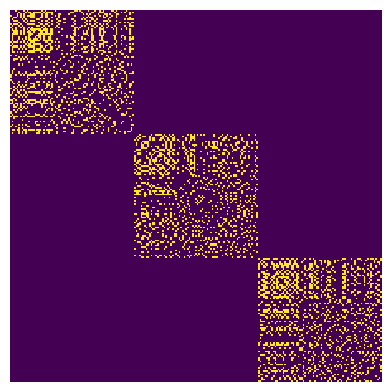

In [9]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj

adj = to_dense_adj(batch.edge_index)[0]
print(f"Matrix dimension: {adj.shape}")
plt.matshow(adj)
plt.axis("off")
plt.show()

# Create random graphs, join them and create a mini-batch

## Create a random graph
To create a basic random graph i.e a `Data` object which only contains $1$ node feature and a sparse graph representation, we can generate random tensors and construct `Data` like in the first example.

In [10]:
def generate_random_graph(num_nodes: int = 75, num_edges: int = 1500) -> Data:
    edges: torch.Tensor = torch.randint(0, num_nodes, (num_edges, 2), dtype=torch.long)
    x: torch.Tensor = torch.rand((num_nodes, 1))
    return Data(x=x, edge_index=edges.t().contiguous()).coalesce()


data: Data = generate_random_graph()
print(f"Graph is valid: {data.validate(raise_on_error=True)}")

Graph is valid: True


In [11]:
%timeit [generate_random_graph() for i in range(1000)]

497 ms ± 7.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Create a Batch from generated data

For creating a Batch from generated `Data` we can use the `classmethod` `Batch.from_data_list()`, from the module `torch_geometric.data.Batch` documented [here](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Batch.html#torch_geometric.data.Batch.from_data_list).

We have to provide a `List[Data]` and set the parameter `follow_batch` with a list of keys that we want to mantain the batch information. (In this example suppose we want to track batch information of `x`)

In [12]:
from torch_geometric.data import Batch
torch.manual_seed(2)

generated_batch: Batch = Batch.from_data_list(
    data_list=[generate_random_graph(4,10) for i in range(2)],
    follow_batch=['x']
)
print(generated_batch)
print(f"First data edges:\n{generated_batch[0].edge_index}")
print(f"Second data edges:\n{generated_batch[1].edge_index}")
print(f"Batch information for x: {generated_batch.x_batch}")
print(f"ptr information: {generated_batch.ptr}")


DataBatch(x=[8, 1], x_batch=[8], x_ptr=[3], edge_index=[2, 14], batch=[8], ptr=[3])
First data edges:
tensor([[0, 1, 1, 2, 2, 2, 3],
        [3, 0, 3, 0, 1, 3, 3]])
Second data edges:
tensor([[0, 1, 2, 2, 2, 3, 3],
        [2, 0, 0, 1, 3, 2, 3]])
Batch information for x: tensor([0, 0, 0, 0, 1, 1, 1, 1])
ptr information: tensor([0, 4, 8])


As we can see, if we access the `edge_index` attribute of a specific data, we get it's specific attribute.
In `x_batch` we can find the index of the graph that has that attribute, i.e. the first four `x` are of graph at index $0$ and the others are of graph at index $1$.

A global position information is stored in the field `ptr`. In this example it says that the first graph node features (`x`) are stored from `[0,4)` and the second is from `[4,8)`.

Like in the previous section, we can plot the gigant matrix if we convert it to dense first.
(For demonstration we will generate a new batch composed of 3 bigger random graphs)

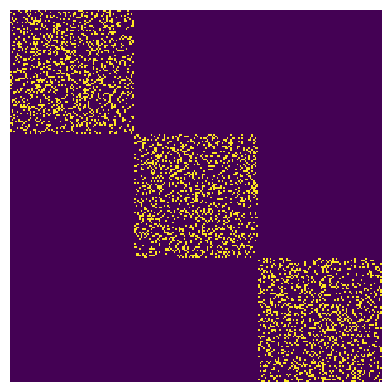

In [13]:
plot_batch: Batch = Batch.from_data_list(
    data_list=[generate_random_graph(75,1500) for i in range(3)],
)

adj = to_dense_adj(plot_batch.edge_index)[0]
plt.matshow(adj)
plt.axis("off")
plt.show()

# Concatenate Batches

Concatenating batches is an expensive operation, since we have to convert the batches in `list`, concatenate them and then tranform them back in a `Batch`.

DataBatch(x=[9, 1], edge_index=[2, 20], batch=[9], ptr=[4])
Concatenated edge_index:
tensor([[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8],
        [0, 2, 0, 1, 2, 0, 1, 2, 3, 4, 5, 5, 4, 5, 7, 8, 6, 8, 7, 8]])
Concateted ptr:
tensor([0, 3, 6, 9])
torch.Size([9, 9])


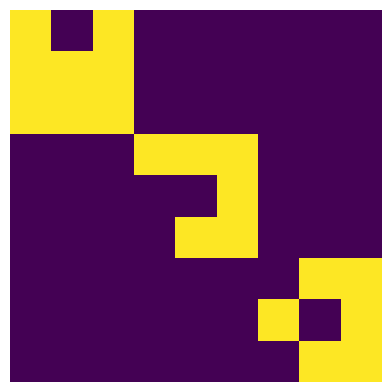

In [20]:
first_batch: Batch = Batch.from_data_list([generate_random_graph(3, 10) for i in range(1)])
second_batch: Batch = Batch.from_data_list([generate_random_graph(3, 10) for i in range(2)])

concatenated: Batch = Batch.from_data_list(
    first_batch.to_data_list() +
    second_batch.to_data_list()
)

print(concatenated)
print(f"Concatenated edge_index:\n{concatenated.edge_index}")
print(f"Concateted ptr:\n{concatenated.ptr}")

adj = to_dense_adj(concatenated.edge_index)[0]
plt.matshow(adj)
plt.axis("off")
plt.show()

# Dense representation

Sometimes want to use the dense representation.
Suppose a more complex example where `num_nodes` vary across graphs.

In [15]:
from torch_geometric.utils import to_dense_batch

data: Batch = Batch.from_data_list([
    generate_random_graph(4, 10),
    generate_random_graph(3, 10),
    generate_random_graph(5, 10)
])
print(f"Node features: {data.x.T}, {data.x.shape}")
print(f"Batch vector: {data.batch}")

Node features: tensor([[0.7487, 0.7893, 0.5693, 0.7754, 0.1346, 0.1483, 0.3696, 0.6327, 0.3391,
         0.0582, 0.3220, 0.1224]]), torch.Size([12, 1])
Batch vector: tensor([0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2])


We can see that the node feature is a `12x1` tensor, because we have $12$ total nodes and $1$ feature.
The bacth vector indicates as usual, at which graphs the nodes belogs.

To get a dense node feature tensor, we can use [to_dense_batch](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.to_dense_batch).

We have to pass the node feature `x`, i.e. `data.x` and the batch vector, i.e. `data.batch`.
The results will be $2$ tensors: the `output` and a `mask`.
The output shape will be `[batch_size, max_num_nodes, features]`. In our example we have, $3$ graphs, the biggest graph has $5$ nodes and theri is just $1$ feature, so we will have a shape of `[3, 5, 1]`.

Note that the smaller graphs will be filled with default values (like `0.`).
To regognize real nodes and fake nodes we will use the `mask`.
The `mask` is a boolean tesor of shape `[batch_size, max_num_node]`. A `True` entry indicates the presence of a real node, and `False` indicates that the node is fake and has been added to match dimension.


In [16]:
out, mask = to_dense_batch(data.x, data.batch)
print(out.shape)
print(mask.shape)
print(mask)

torch.Size([3, 5, 1])
torch.Size([3, 5])
tensor([[ True,  True,  True,  True, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True,  True]])


For representing a dense adjency matrix we use [to_dense_adj](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.to_dense_adj).

We 

In [17]:
adj = to_dense_adj(data.edge_index, data.batch)
adj
adj.shape  # batch_size, num_nodes, num_nodes

torch.Size([3, 5, 5])

In [18]:
edge_attr = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0],
                          [1.0, 2.0, 3.0, 4.0, 5.0]])


data_list = [generate_random_graph(5,10)]
data = Batch.from_data_list(data_list)

edge_attr = torch.rand((data.edge_index.shape[1]))
print(data)
print(edge_attr)

data.edge_attr = edge_attr

adj = to_dense_adj(data.edge_index, edge_attr=data.edge_attr)

print(adj)

DataBatch(x=[5, 1], edge_index=[2, 8], batch=[5], ptr=[2])
tensor([0.8081, 0.3924, 0.2132, 0.5028, 0.9025, 0.2942, 0.0811, 0.8372])
tensor([[[0.8081, 0.0000, 0.3924, 0.0000, 0.0000],
         [0.0000, 0.2132, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5028, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.9025, 0.0000, 0.2942],
         [0.0000, 0.0811, 0.0000, 0.0000, 0.8372]]])


# Convert back to sparse

In [26]:
from typing import Tuple, List
from torch_geometric.utils import dense_to_sparse


def densify(data: Batch) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    x, mask = to_dense_batch(data.x, data.batch)
    adj = to_dense_adj(data.edge_index, data.batch)
    return x, adj, mask


def to_sparse_list(x, adj, mask, ptr) -> List[Data]:
    data = []
    for i in range(1, len(ptr)):
        sparse_x = x[mask][ptr[i-1]:ptr[i]]
        edge_index = dense_to_sparse(adj[i-1], mask)
        data.append(Data(x=sparse_x, edge_index=edge_index))
    return data


test = Batch.from_data_list([
    generate_random_graph(5, 10),
    generate_random_graph(4, 10),
    generate_random_graph(3, 10)
])

x, adj, mask = densify(test)

print(adj[0])
print(torch.transpose(adj, 1, 2)[0])

print(Batch.to_data_list(test))
print(to_sparse_list(x, adj, mask, test.ptr))


tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1.]])
tensor([[0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]])
[Data(x=[5, 1], edge_index=[2, 7]), Data(x=[4, 1], edge_index=[2, 9]), Data(x=[3, 1], edge_index=[2, 7])]
[Data(x=[5, 1], edge_index=[2]), Data(x=[4, 1], edge_index=[2]), Data(x=[3, 1], edge_index=[2])]
